This method, in a nutshell:

Finds the mean diurnal cycle (mdc(d)) over each day (d) of the calendar year for 40 years, with mean zero, and range 1

For each target date (t), we know Tmax, Tmin (and therefore Trange) and Tmean, and so can take T(t) = Tmin + Trange * (mdc(d) - min(mdc(d)), 
where d is the calendar day of date t

We think that T(t)(00) !< Tmin(t-1), and similarly T(t)(23) !< Tmin(t+1), so can rescale the tails to prevent some undershoots 
(but not all - Tmin will either be in the morning or at night...)

But more than that, there should not be sharp jumps at either side, so can smooth these out over 21, 22, 23, 00, 01, 02

And then we re-scale again to preserve our key knowledge of the daily mean temperature.

In [75]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import shapely.geometry
import pandas as pd
import datetime
import iris
import iris.coord_categorisation
from eval_case_study_function2 import RMS_based_eval

iananmean = iris.analysis.Aggregator('nanmean', np.nanmean)

In [97]:
from importlib import reload
reload(eval_case_study_function2)

<module 'eval_case_study_function2' from '/home/users/train039/jbranch/group_1/eval_case_study_function2.py'>

In [76]:
t2m_all = iris.load_cube('UK_mean_timeseries_t2m_1979_2016.nc')

daycoord = t2m_all[::24].coord('time')
hourcoord = iris.coords.DimCoord(np.arange(24), long_name='hour_of_day', units='hours', circular=True)

/opt/jaspy/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1725: UnknownCellMethodWarning: NetCDF variable 't2m' contains unknown cell method 'nanmean'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)


In [77]:
t2m_reshape = iris.cube.Cube(t2m_all.data.reshape([len(daycoord.points), len(hourcoord.points)]), 
                             long_name=t2m_all.name(), units=t2m_all.units, dim_coords_and_dims=[(daycoord, 0), (hourcoord, 1)])

In [78]:
iris.coord_categorisation.add_day_of_year(t2m_reshape, 'time')
iris.coord_categorisation.add_year(t2m_reshape, 'time')

In [79]:
print(t2m_reshape)

print(t2m_reshape[0, 7].data)
print(t2m_all[7].data)

print(t2m_reshape[10, 10].data)
print(t2m_all[24*10 + 10].data)

2 metre temperature / (K)           (time: 13870; hour_of_day: 24)
     Dimension coordinates:
          time                           x                   -
          hour_of_day                    -                   x
     Auxiliary coordinates:
          day_of_year                    x                   -
          year                           x                   -
267.3597893143872
267.3597893143872
274.700150929442
274.700150929442


In [80]:
t2m_mean = t2m_reshape.collapsed('hour_of_day', iananmean)
t2m_max = t2m_reshape.collapsed('hour_of_day', iris.analysis.MAX)
t2m_min = t2m_reshape.collapsed('hour_of_day', iris.analysis.MIN)
t2m_range = t2m_max - t2m_min

t2m_normalised = (t2m_reshape - t2m_mean)/t2m_range

#t2m_normalised has mean zero, and range 1

/opt/jaspy/lib/python3.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'hour_of_day'.
  warnings.warn(msg.format(self.name()))


In [81]:
t2m_seasonal = t2m_normalised.aggregated_by(['day_of_year'], iananmean)

unknown / (1)                       (-- : 366; hour_of_day: 24)
     Dimension coordinates:
          hour_of_day                   -                 x
     Auxiliary coordinates:
          day_of_year                   x                 -
          time                          x                 -
          year                          x                 -
     Cell methods:
          nanmean: day_of_year


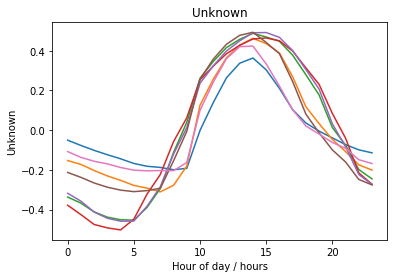

In [82]:
print(t2m_seasonal)
import iris.quickplot as qplt
for i in np.arange(1, 360, 55):
    qplt.plot(t2m_seasonal[i])
plt.show()

In [83]:
case_no = '1'
field = 'T2m'
obs = np.loadtxt('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_' + field + '.dat')
obs_date = np.load('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_date.npy')

In [84]:
# Case 1: 7 days

obs_days = np.reshape(np.array(obs), [7, 24])
obs_dates = np.reshape(obs_date, [7, 24])

monthoffset = [0, 1, -1, 0, 0, 1, 1, 2, 3, 3, 4, 4]
# (monthno-1)*30 + monthoffset + date = day

downscaled_days = np.zeros_like(obs_days)
for i in np.arange(7):
    
    Tmean = np.mean(obs_days[i, :])
    Tmax = np.max(obs_days[i, :])
    Tmin = np.min(obs_days[i, :])
    Trange = Tmax - Tmin
    # extract permitted information: daily mean, daily max, daily min
    
    month = int(str(obs_dates[i, 0])[5:7])
    date = int(str(obs_dates[i, 0])[8:10])
    day = (month-1)*30 + monthoffset[month-1] + date
    
    #downscaled_days[i, :] = Tmin + Trange*(t2m_seasonal.data[day, :] - np.min(t2m_seasonal.data[day, :]))
    downscaled_days[i, :] = Tmean + Trange*t2m_seasonal.data[day, :]
    # t2m_seasonal is the mean diurnal cycle over each day of the calendar year for 40 years, with mean zero, and range 1

In [85]:
# Now we extend this to use the minimum temperatures from the days before (morning, M) and after (night, N)
# but not for the endpoints of the obs days, because I'm too lazy to go get the data from a broader period
for i in np.arange(7):
    
    if i != 0:
        
        TminM = np.min(obs_days[i-1, :])
        # information from climate model
        
        TmaxD = np.max(downscaled_days[i, :])
        argmax = np.argmax(downscaled_days[i, :])
        # information from our first guess
        
        if downscaled_days[i, 0] < TminM:
            # if we've said it's colder at midnight00 than yesterday's minumum
            downscaled_days[i, :argmax+1] = TmaxD + ( (downscaled_days[i, :argmax+1] - TmaxD) * 
                                                     ( ( TmaxD - TminM ) / (TmaxD - downscaled_days[i, 0] )) )
            # then re-scale the first half of the sinusoid such that now the midnight00 value is yesterday's minimum, 
            # keeping today's maximum the same
            
    if i != 6:
        
        TminN = np.min(obs_days[i+1, :])
        # information from climate model
        
        TmaxD = np.max(downscaled_days[i, :])
        argmax = np.argmax(downscaled_days[i, :])
        # information from our first guess
        
        if downscaled_days[i, -1] < TminN:
            # if we've said it's colder at midnight23 than tomorrow's minumum
            downscaled_days[i, argmax:] = TmaxD + ( (downscaled_days[i, argmax:] - TmaxD) * 
                                                     ( ( TmaxD - TminN ) / (TmaxD - downscaled_days[i, -1] )) )
            # then re-scale the second half of the sinusoid such that now the midnight23 value is tomorrow's minimum, 
            # keeping today's maximum the same

In [86]:
# Now smooth out large disagreement between consecutive days

for i in np.arange(1, 7):
    
    if (downscaled_days[i, 0] - downscaled_days[i-1, -1]) > 1.5*np.max([np.abs(downscaled_days[i, 1] - downscaled_days[i, 0]), 
                                                                              np.abs(downscaled_days[i-1, -2] - downscaled_days[i-1, -1])]):
        # if the difference in one hour between two cases is larger than the difference expected from an nour and a half, it's too large
        
        # assume the day before is fine (meritless assumption)
        
        TminD = np.min(downscaled_days[i, :argmax])
        argmin = np.argmin(downscaled_days[i, :argmax])
        # information from our first guess
        
        downscaled_days[i, :argmin+1] = TminD + ( (downscaled_days[i, :argmin+1] - TminD) * 
                                                     ( ( TminD - downscaled_days[i-1, -1] ) / (TminD - downscaled_days[i, 0] )) )
        # re-scale the morning
        
        #Tdiff = (downscaled_days[i, 2] - downscaled_days[i-1, -2])/4
        #downscaled_days[i, 1] = downscaled_days[i, 2] - Tdiff
        #downscaled_days[i, 0] = downscaled_days[i, 2] - 2*Tdiff
        #downscaled_days[i-1, -1] = downscaled_days[i-1, -2] + Tdiff
        # linearly fit the morning

    Tmean = np.mean(obs_days[i, :])
    # use the known daily mean for i-1 again
       
    downscaled_days[i, :] = downscaled_days[i, :] * (Tmean / np.mean(downscaled_days[i, :]))
    
    #fudge_factor = 1
    
    #fudge_series = (downscaled_days[i, :] - np.mean(downscaled_days[i, :])) * (Trange / (np.max(downscaled_days[i, :]) - np.min(downscaled_days[i, :]))) + Tmean
    # Nudge the mean and range back to where I want them to be
    # This will also drag the minima down again, but I'm not iterating this and can't think of anything better right now
    
    #downscaled_days[i, :] = (1 - fudge_factor)*downscaled_days[i, :] + fudge_factor*fudge_series

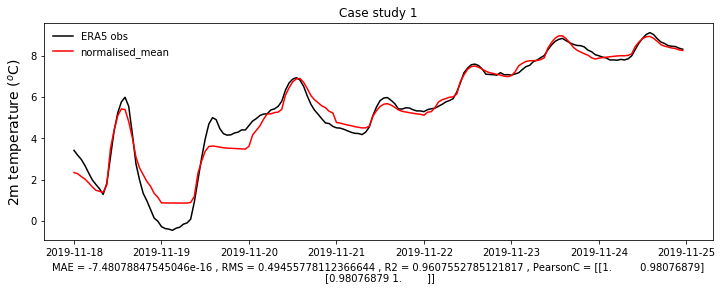

[-7.48078847545046e-16,
 0.49455778112366644,
 0.9607552785121817,
 array([[1.        , 0.98076879],
        [0.98076879, 1.        ]])]

In [98]:
downscale_ts = np.reshape(downscaled_days, [168])
eval_case_study_function2.RMS_based_eval(downscale_ts,'T2m','1','normalised_mean')

In [64]:
case_no = '2'
field = 'T2m'
obs = np.loadtxt('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_' + field + '.dat')
obs_date = np.load('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_date.npy')

In [65]:
# Case 2: 9 days
nd = 9

obs_days = np.reshape(np.array(obs), [nd, 24])
obs_dates = np.reshape(obs_date, [nd, 24])

monthoffset = [0, 1, -1, 0, 0, 1, 1, 2, 3, 3, 4, 4]
# (monthno-1)*30 + monthoffset + date = day

downscaled_days2 = np.zeros_like(obs_days)
for i in np.arange(nd):
    
    Tmean = np.mean(obs_days[i, :])
    Tmax = np.max(obs_days[i, :])
    Tmin = np.min(obs_days[i, :])
    Trange = Tmax - Tmin
    # extract permitted information: daily mean, daily max, daily min
    
    month = int(str(obs_dates[i, 0])[5:7])
    date = int(str(obs_dates[i, 0])[8:10])
    day = (month-1)*30 + monthoffset[month-1] + date
    
    downscaled_days2[i, :] = Tmean + Trange*t2m_seasonal.data[day, :]
    # t2m_seasonal is the mean diurnal cycle over each day of the calendar year for 40 years, with mean zero, and range 1

In [66]:
# Now we extend this to use the minimum temperatures from the days before (morning, M) and after (night, N)
# but not for the endpoints of the obs days, because I'm too lazy to go get the data from a broader period
for i in np.arange(nd):
    
    if i != 0:
        
        TminM = np.min(obs_days[i-1, :])
        # information from climate model
        
        TmaxD = np.max(downscaled_days2[i, :])
        argmax = np.argmax(downscaled_days2[i, :])
        # information from our first guess
        
        if downscaled_days2[i, 0] < TminM:
            # if we've said it's colder at midnight00 than yesterday's minumum
            downscaled_days2[i, :argmax+1] = TmaxD + ( (downscaled_days2[i, :argmax+1] - TmaxD) * 
                                                     ( ( TmaxD - TminM ) / (TmaxD - downscaled_days2[i, 0] )) )
            # then re-scale the first half of the sinusoid such that now the midnight00 value is yesterday's minimum, 
            # keeping today's maximum the same
            
    if i != nd-1:
        
        TminN = np.min(obs_days[i+1, :])
        # information from climate model
        
        TmaxD = np.max(downscaled_days2[i, :])
        argmax = np.argmax(downscaled_days2[i, :])
        # information from our first guess
        
        if downscaled_days2[i, -1] < TminN:
            # if we've said it's colder at midnight23 than tomorrow's minumum
            downscaled_days2[i, argmax:] = TmaxD + ( (downscaled_days2[i, argmax:] - TmaxD) * 
                                                     ( ( TmaxD - TminN ) / (TmaxD - downscaled_days2[i, -1] )) )
            # then re-scale the second half of the sinusoid such that now the midnight23 value is tomorrow's minimum, 
            # keeping today's maximum the same
            
  

In [68]:
# Now smooth out large disagreement between consecutive days

for i in np.arange(1, nd):
    
    if (downscaled_days2[i, 0] - downscaled_days2[i-1, -1]) > 1.5*np.max([np.abs(downscaled_days2[i, 1] - downscaled_days2[i, 0]), 
                                                                              np.abs(downscaled_days2[i-1, -2] - downscaled_days2[i-1, -1])]):
        # if the difference in one hour between two cases is larger than the difference expected from an nour and a half, it's too large
        
        # assume the day before is fine (meritless assumption)
        
        TminD = np.min(downscaled_days2[i, :argmax])
        argmin = np.argmin(downscaled_days2[i, :argmax])
        # information from our first guess
        
        downscaled_days2[i, :argmin+1] = TminD + ( (downscaled_days2[i, :argmin+1] - TminD) * 
                                                     ( ( TminD - downscaled_days2[i-1, -1] ) / (TminD - downscaled_days2[i, 0] )) )
        # re-scale the morning

    Tmean = np.mean(obs_days[i, :])
    # use the known daily mean for i-1 again
       
    downscaled_days2[i, :] = downscaled_days2[i, :] * (Tmean / np.mean(downscaled_days2[i, :]))

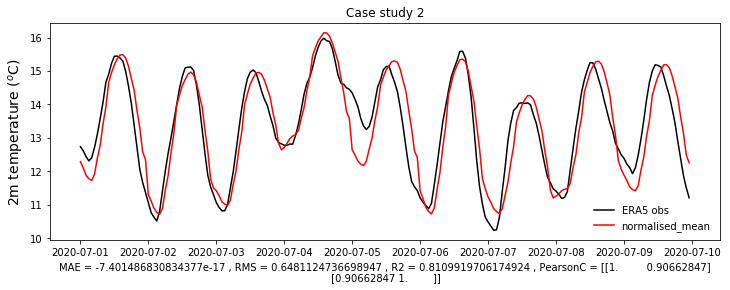

[-7.401486830834377e-17,
 0.6481124736698947,
 0.8109919706174924,
 array([[1.        , 0.90662847],
        [0.90662847, 1.        ]])]

In [100]:
downscale_ts = np.reshape(downscaled_days2, [216])
eval_case_study_function2.RMS_based_eval(downscale_ts,'T2m','2','normalised_mean')
#print(MAE)
#print(RMS)

In [70]:
case_no = '3'
field = 'T2m'
obs = np.loadtxt('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_' + field + '.dat')
obs_date = np.load('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_date.npy')

In [71]:
# Case 3: 28 days
nd = 28

obs_days = np.reshape(np.array(obs), [nd, 24])
obs_dates = np.reshape(obs_date, [nd, 24])

monthoffset = [0, 1, -1, 0, 0, 1, 1, 2, 3, 3, 4, 4]
# (monthno-1)*30 + monthoffset + date = day

downscaled_days3 = np.zeros_like(obs_days)
for i in np.arange(nd):
    
    Tmean = np.mean(obs_days[i, :])
    Tmax = np.max(obs_days[i, :])
    Tmin = np.min(obs_days[i, :])
    Trange = Tmax - Tmin
    # extract permitted information: daily mean, daily max, daily min
    
    month = int(str(obs_dates[i, 0])[5:7])
    date = int(str(obs_dates[i, 0])[8:10])
    day = (month-1)*30 + monthoffset[month-1] + date
    
    downscaled_days3[i, :] = Tmean + Trange*t2m_seasonal.data[day, :]
    # t2m_seasonal is the mean diurnal cycle over each day of the calendar year for 40 years, with mean zero, and range 1

In [72]:
# Now we extend this to use the minimum temperatures from the days before (morning, M) and after (night, N)
# but not for the endpoints of the obs days, because I'm too lazy to go get the data from a broader period
for i in np.arange(nd):
    
    if i != 0:
        
        TminM = np.min(obs_days[i-1, :])
        # information from climate model
        
        TmaxD = np.max(downscaled_days3[i, :])
        argmax = np.argmax(downscaled_days3[i, :])
        # information from our first guess
        
        if downscaled_days3[i, 0] < TminM:
            # if we've said it's colder at midnight00 than yesterday's minumum
            downscaled_days3[i, :argmax+1] = TmaxD + ( (downscaled_days3[i, :argmax+1] - TmaxD) * 
                                                     ( ( TmaxD - TminM ) / (TmaxD - downscaled_days3[i, 0] )) )
            # then re-scale the first half of the sinusoid such that now the midnight00 value is yesterday's minimum, 
            # keeping today's maximum the same
            
    if i != nd-1:
        
        TminN = np.min(obs_days[i+1, :])
        # information from climate model
        
        TmaxD = np.max(downscaled_days3[i, :])
        argmax = np.argmax(downscaled_days3[i, :])
        # information from our first guess
        
        if downscaled_days3[i, -1] < TminN:
            # if we've said it's colder at midnight23 than tomorrow's minumum
            downscaled_days3[i, argmax:] = TmaxD + ( (downscaled_days3[i, argmax:] - TmaxD) * 
                                                     ( ( TmaxD - TminN ) / (TmaxD - downscaled_days3[i, -1] )) )
            # then re-scale the second half of the sinusoid such that now the midnight23 value is tomorrow's minimum, 
            # keeping today's maximum the same
        

In [73]:
# Now smooth out large disagreement between consecutive days

for i in np.arange(1, nd):
    
    if (downscaled_days3[i, 0] - downscaled_days3[i-1, -1]) > 1.5*np.max([np.abs(downscaled_days3[i, 1] - downscaled_days3[i, 0]), 
                                                                              np.abs(downscaled_days3[i-1, -2] - downscaled_days3[i-1, -1])]):
        # if the difference in one hour between two cases is larger than the difference expected from an nour and a half, it's too large
        
        # assume the day before is fine (meritless assumption)
        
        TminD = np.min(downscaled_days3[i, :argmax])
        argmin = np.argmin(downscaled_days3[i, :argmax])
        # information from our first guess
        
        downscaled_days3[i, :argmin+1] = TminD + ( (downscaled_days3[i, :argmin+1] - TminD) * 
                                                     ( ( TminD - downscaled_days3[i-1, -1] ) / (TminD - downscaled_days3[i, 0] )) )
        # re-scale the morning

    Tmean = np.mean(obs_days[i, :])
    # use the known daily mean for i-1 again
       
    downscaled_days3[i, :] = downscaled_days3[i, :] * (Tmean / np.mean(downscaled_days3[i, :]))

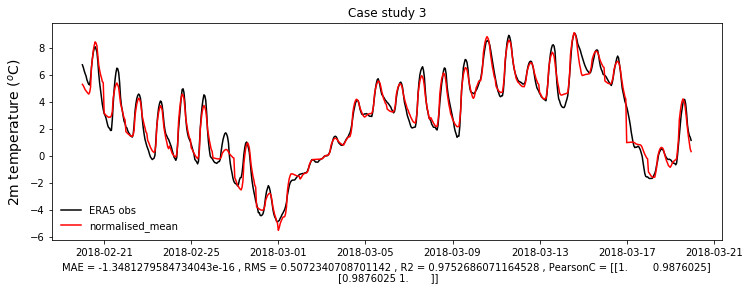

[-1.3481279584734043e-16,
 0.5072340708701142,
 0.9752686071164528,
 array([[1.       , 0.9876025],
        [0.9876025, 1.       ]])]

In [101]:
downscale_ts = np.reshape(downscaled_days3, [672])
#MAE, RMS = 
eval_case_study_function2.RMS_based_eval(downscale_ts,'T2m','3','normalised_mean')
#print(MAE)
#print(RMS)